In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

import matplotlib.pyplot as plt
from figurefirst import mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc

import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import accuracy_score, classification_report
from concurrent.futures import ProcessPoolExecutor



### Gaussian Processes

In [27]:
# Define a simpler kernel (just RBF)
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    # Load the data
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    # Subsample the data for faster training 
    data_subsample = df.sample(frac=0.9)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor_binary'].values  
    
    # X = df[['distance_along_streakline', 'nearest_from_streakline']].values
    # y = df['odor_binary'].values  
    
    # Create and train the GP regressor with reduced restarts
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
    gp.fit(X, y)
    
    return gp, file_path

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Dictionary to store trained models with file paths as keys
trained_models = {}

# Using a ProcessPoolExecutor to parallelize the training
num_cores = 50
with ProcessPoolExecutor(num_cores) as executor:
    for gp_model, file_path in executor.map(train_gp_for_file, all_files):
        trained_models[file_path] = gp_model
        print(f"Completed training for file: {file_path}")

/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag32.h5


/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag50.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag12.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag15.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag6.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag52.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag41.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag10.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag29.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plum

/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag24.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag34.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag40.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag48.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag28.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag11.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag46.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag26.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag2.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag9.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag5.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1

In [43]:
# from joblib import dump

# # Save the trained model to a file
# dump(trained_models, '../assets/models/gp_model_90_2023Nov1.joblib')


# from joblib import load
# # Load the trained_models dictionary from the file
# trained_models_loaded = load('../assets/models/gp_model_90_2023Nov1.joblib')

Accuracy: 0.97


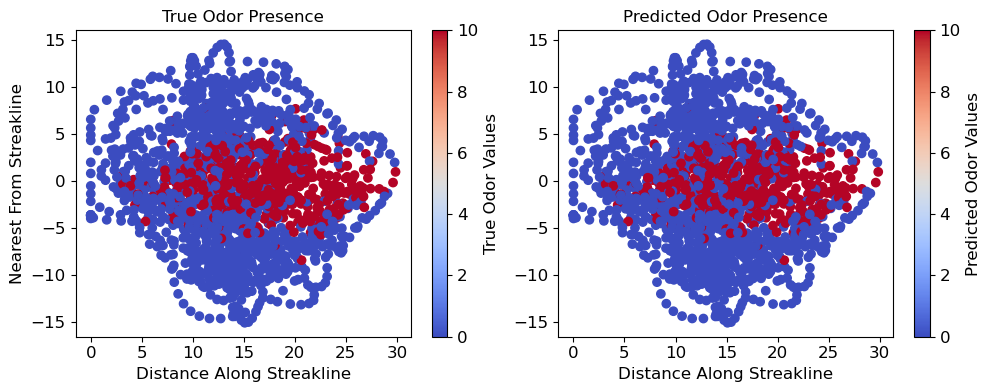

In [53]:
# Testing phase
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag51.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor_binary'].values

# Make predictions using the retrieved GP model
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)
y_pred_binary = np.where(y_pred_mean > 5, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")
# print(f"Classification report: {report}")

f, axes = plt.subplots(1,2, figsize=(10, 4))

sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Scatter plot for predicted odor values
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')
# axes[1].set_ylabel('Nearest From Streakline')

f.tight_layout()

mpl_functions.set_fontsize(f, 12)


In [60]:
# Choose a representative trained model
representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5"  # Modify this to an actual training file path
gp_representative = trained_models[representative_file_path]

# Path to the new test file
test_file_path = "/home/beast/An/data/Sept13Plumes/plume3/train/diag21.h5"
test_df = pd.read_hdf(test_file_path)

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor_binary'].values

# Make predictions using the chosen GP model
y_pred_mean, y_pred_std = gp_representative.predict(X_test, return_std=True)
y_pred_binary = np.where(y_pred_mean > 5, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
# report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8331428571428572


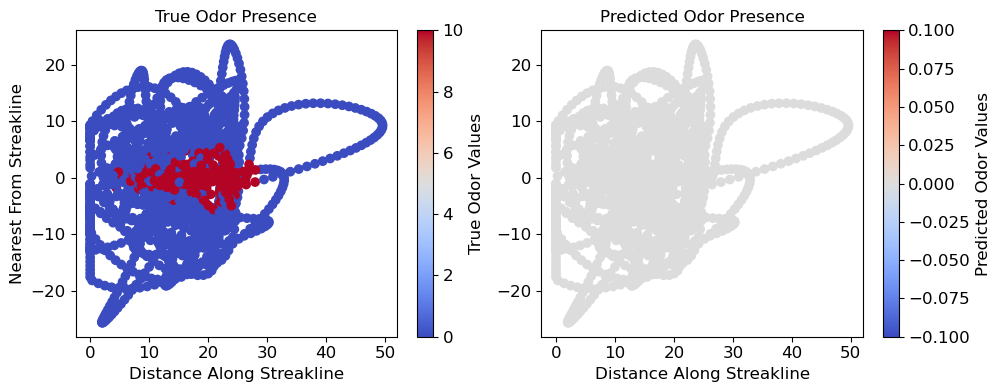

In [61]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot for true odor values
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Scatter plot for predicted odor values
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')
# Omitting y-label for the second plot for clarity

f.tight_layout()

mpl_functions.set_fontsize(f, 12)

NameError: name 'col' is not defined

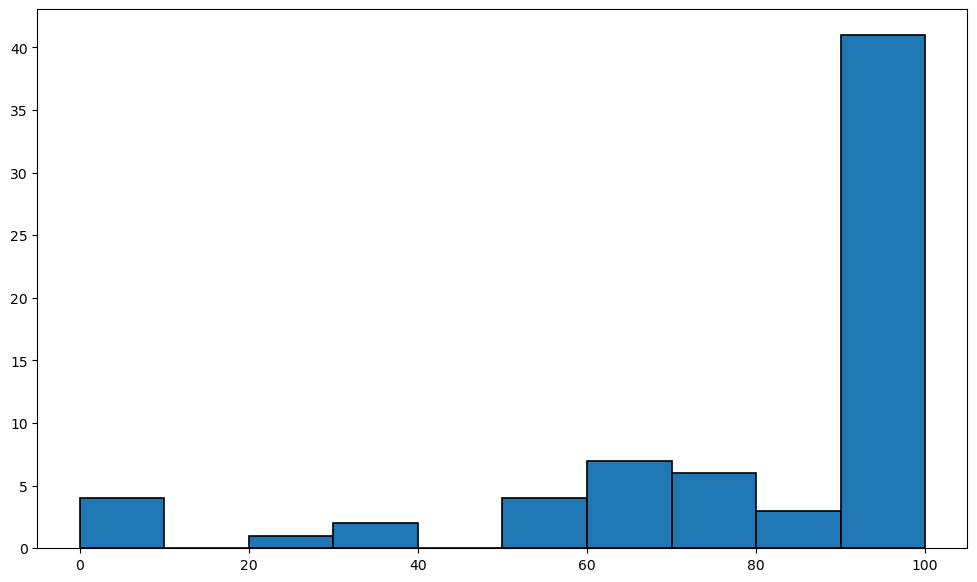

In [62]:
# Student scores data
scores = [
    70, 100, 0, 95, 97, 100, 100, 52, 100, 65, 30, 100, 63, 70, 62, 93, 0, 0, 100, 
    69, 90, 67, 77, 100, 75, 57, 52, 73, 83, 100, 93, 100, 96, 60, 72, 100, 88, 100,
    100, 100, 83, 95, 20, 95, 90, 93, 95, 90, 100, 95, 35, 0, 100, 100, 93, 100, 97, 
    65, 93, 100, 50, 100, 100, 100, 100, 100, 100, 100
]

# Using the "Blues" color palette
colors = plt.cm.Blues

# Create histogram with the "Blues" color palette
plt.figure(figsize=(12, 7))
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black', linewidth=1.2)

# Color code by height using the "Blues" colormap
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', colors(c))

plt.title('Histogram of Student Scores', fontsize=16, fontweight='bold')
plt.xlabel('Scores', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)